# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131

## Витрина данных по участникам Kiev Major

## Финальный файл скрипта: ABT_[DATE].csv

В данном скрипте представлена таблица по командам, которые указаны в файле Dota Features & Snippets - Roles.csv за период с 1 января 2017 года по сегодняшний день. Строка таблицы - информация о матче на уровне игрока. Т.е. если между IG и LGD был матч с match_id = 12345, то таблица содержит 10 записей с данным идентификаторм для каждого конкретного account_id.

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import requests
from datetime import datetime
import time
from requests.auth import HTTPBasicAuth
import sys
import io
import datetime
import math 
import sklearn 

In [2]:
def download_google_spreadsheet(url):
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        content_bytes = resp.content
    except requests.exceptions.HTTPError as err:
        print(err, file=sys.stderr)
    try:
        content = pd.read_csv(io.BytesIO(content_bytes))
        return content
    except Exception as err:
        print("failed to convert bytes to csv:", err, file=sys.stderr)

In [3]:
def query_opendota(sql):
    resp = requests.get('https://api.opendota.com/api/explorer', params={'sql': sql})
    data = resp.json()
    if resp.status_code == 400 and data is not None:
        sys.stderr.write(data['err'])
    resp.raise_for_status()
    return pd.DataFrame.from_records(data['rows'])

In [94]:
def query_ward_table():
    df_wards = query_opendota('''
SELECT
    -- Basic table
    matches.match_id,
    player_matches.account_id,
    teams.team_id,
    matches.leagueid,
    leagues.name leaguename,
    matches.start_time,
    player_matches.hero_id,
    player_matches.player_slot,
    ((player_matches.player_slot < 128) = matches.radiant_win) win,
        player_matches.kills,
    player_matches.deaths,
    player_matches.assists,
    player_matches.gold_per_min ,
    player_matches.xp_per_min ,
    player_matches.gold_spent ,
    player_matches.hero_damage ,
    player_matches.tower_damage ,
    player_matches.stuns ,
    player_matches.creeps_stacked ,
    player_matches.camps_stacked ,
    player_matches.hero_healing ,
    player_matches.last_hits,
    player_matches.denies,
    player_matches.level,
    matches.duration,
    matches.cluster,
    matches.first_blood_time,

    --timeStamp variables
    player_matches.gold_t[3] t_Gold_cnt_3,
    player_matches.gold_t[5] t_Gold_cnt_5,
    player_matches.gold_t[8] t_Gold_cnt_8,
    player_matches.gold_t[10] t_Gold_cnt_10,
    player_matches.gold_t[12] t_Gold_cnt_12,
    player_matches.gold_t[15] t_Gold_cnt_15,
    player_matches.gold_t[20] t_Gold_cnt_20,
    player_matches.gold_t[25] t_Gold_cnt_25,
    player_matches.gold_t[30] t_Gold_cnt_30,

    player_matches.lh_t[3] t_LastHits_cnt_3,
    player_matches.lh_t[5] t_LastHits_cnt_5,
    player_matches.lh_t[8] t_LastHits_cnt_8,
    player_matches.lh_t[10] t_LastHits_cnt_10,
    player_matches.lh_t[12] t_LastHits_cnt_12,
    player_matches.lh_t[15] t_LastHits_cnt_15,
    player_matches.lh_t[20] t_LastHits_cnt_20,
    player_matches.lh_t[25] t_LastHits_cnt_25,
    player_matches.lh_t[30] t_LastHits_cnt_30,

    player_matches.xp_t[3] t_Experience_cnt_3,
    player_matches.xp_t[5] t_Experience_cnt_5,
    player_matches.xp_t[8] t_Experience_cnt_8,
    player_matches.xp_t[10] t_Experience_cnt_10,
    player_matches.xp_t[12] t_Experience_cnt_12,
    player_matches.xp_t[15] t_Experience_cnt_15,
    player_matches.xp_t[20] t_Experience_cnt_20,
    player_matches.xp_t[25] t_Experience_cnt_25,
    player_matches.xp_t[30] t_Experience_cnt_30,

    player_matches.pings ping_log,
    player_matches.obs_log,
    player_matches.sen_log,
    player_matches.runes_log,
    player_matches.kills_log,
    player_matches.buyback_log,
    
    player_matches.gold_reasons,

    --table_heroStats
    heroes.localized_name,
    heroes.attack_type,
    heroes.primary_attr,
    heroes.roles role_log,

    --purchase_log
    player_matches.purchase_log
FROM 
    matches
        JOIN match_patch using(match_id)
        JOIN leagues using(leagueid)
        JOIN player_matches using(match_id)
        JOIN heroes on heroes.id = player_matches.hero_id
        LEFT JOIN notable_players ON notable_players.account_id = player_matches.account_id AND notable_players.locked_until = (SELECT MAX(locked_until) FROM notable_players)
        LEFT JOIN teams using(team_id)
WHERE TRUE
    AND matches.leagueid = 5401 OR matches.leagueid = 4442
    AND matches.start_time >= extract(epoch from timestamp '2017-06-30T21:00:00.000Z')
    AND teams.team_id IN (5, 15, 39, 46, 2163, 350190, 1375614, 1838315, 1883502, 2108395, 2512249, 2581813, 2586976, 2640025, 2672298, 1333179, 3331948, 1846548)
ORDER BY 
    matches.match_id DESC NULLS LAST
    LIMIT 10000
    '''.format(**locals()))
    return df_wards

# Загружаем данные в формате json, парсим и сохраняем в Pandas

Предварительно ссылку стоит открыть в браузере, иначе она не хочет грузиться (слишком большая?)

In [95]:
matches = query_ward_table()
matches['id'] = matches['match_id'].astype('str') + "_" + matches['account_id'].astype('str')
print(matches.shape)
matches['datetime'] = matches["start_time"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%d.%m.%Y %H:%M:%S'))

(5616, 67)


# Добавляем уникальный идентификатор matchId_accountId и дату

In [96]:
matches['id'] = matches['match_id'].astype('str') + "_" + matches['account_id'].astype('str')
print(matches.shape)
matches['datetime'] = matches["start_time"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%d.%m.%Y %H:%M:%S'))

(5616, 68)


In [134]:
df_gold_reasons = matches['gold_reasons'].apply(pd.Series)
for col in df_gold_reasons.columns:
    df_gold_reasons.rename(columns={col: '{}_{}'.format('gold_reason', col)}, inplace=True)
df_gold_reasons.head()

,gold_reason_0,gold_reason_1,gold_reason_11,gold_reason_12,gold_reason_13,gold_reason_14,gold_reason_15,gold_reason_2,gold_reason_5,gold_reason_6
0,880.0,-1012.0,440.0,844.0,7260.0,NaN,NaN,NaN,NaN,25.0
1,1168.0,-718.0,440.0,1435.0,795.0,NaN,NaN,NaN,NaN,137.0
2,1103.0,-652.0,632.0,1240.0,5927.0,NaN,NaN,NaN,NaN,200.0
3,925.0,-420.0,440.0,1792.0,692.0,NaN,NaN,NaN,NaN,NaN
4,923.0,-1301.0,889.0,969.0,6859.0,NaN,NaN,NaN,NaN,NaN


# Список переменных

In [8]:
list(matches)

['account_id',
 'assists',
 'attack_type',
 'buyback_log',
 'camps_stacked',
 'cluster',
 'creeps_stacked',
 'deaths',
 'denies',
 'duration',
 'first_blood_time',
 'gold_per_min',
 'gold_spent',
 'hero_damage',
 'hero_healing',
 'hero_id',
 'kills',
 'kills_log',
 'last_hits',
 'leagueid',
 'leaguename',
 'level',
 'localized_name',
 'match_id',
 'obs_log',
 'ping_log',
 'player_slot',
 'primary_attr',
 'purchase_log',
 'role_log',
 'runes_log',
 'sen_log',
 'start_time',
 'stuns',
 't_experience_cnt_10',
 't_experience_cnt_12',
 't_experience_cnt_15',
 't_experience_cnt_20',
 't_experience_cnt_25',
 't_experience_cnt_3',
 't_experience_cnt_30',
 't_experience_cnt_5',
 't_experience_cnt_8',
 't_gold_cnt_10',
 't_gold_cnt_12',
 't_gold_cnt_15',
 't_gold_cnt_20',
 't_gold_cnt_25',
 't_gold_cnt_3',
 't_gold_cnt_30',
 't_gold_cnt_5',
 't_gold_cnt_8',
 't_lasthits_cnt_10',
 't_lasthits_cnt_12',
 't_lasthits_cnt_15',
 't_lasthits_cnt_20',
 't_lasthits_cnt_25',
 't_lasthits_cnt_3',
 't_lasth

In [9]:
matches.groupby('match_id', as_index=False).last()[['match_id', 'datetime']].tail(48).match_id.tolist()

[3372622939,
 3372676225,
 3372726385,
 3428229571,
 3428302772,
 3442422325,
 3442480297,
 3444110210,
 3444185690,
 3446029118,
 3446105401,
 3448037380,
 3448171489,
 3448470602,
 3448529994,
 3450535143,
 3450608497,
 3450683382,
 3453799086,
 3453910490,
 3455679928,
 3455787956,
 3455876158,
 3548237028,
 3548362140,
 3548515278,
 3548643001,
 3549016458,
 3549071620,
 3549145408,
 3549205058,
 3549257953,
 3550198389,
 3550304896,
 3551325652,
 3551396595,
 3551461157,
 3551555634,
 3551643758,
 3551813576,
 3551919843,
 3552018378,
 3552431131,
 3552521258,
 3552645241,
 3552680898,
 3561318259,
 3561414435]

In [10]:
matches.head()

,account_id,assists,attack_type,buyback_log,camps_stacked,cluster,creeps_stacked,deaths,denies,duration,...,t_lasthits_cnt_3,t_lasthits_cnt_30,t_lasthits_cnt_5,t_lasthits_cnt_8,team_id,tower_damage,win,xp_per_min,id,datetime
0,111189717,6,Melee,[],2.0,224,6.0,3,12,1704,...,7.0,146.0,15.0,19.0,3331948.0,784,False,442,3561414435_111189717,14.11.2017 13:35:24
1,148215639,7,Ranged,[],0.0,224,0.0,6,13,1704,...,5.0,155.0,7.0,16.0,3331948.0,1318,False,355,3561414435_148215639,14.11.2017 13:35:24
2,90882159,5,Ranged,[],0.0,224,0.0,4,12,1704,...,3.0,162.0,10.0,19.0,3331948.0,373,False,451,3561414435_90882159,14.11.2017 13:35:24
3,114239371,6,Melee,[],0.0,224,0.0,6,1,1704,...,0.0,19.0,0.0,0.0,3331948.0,134,False,280,3561414435_114239371,14.11.2017 13:35:24
4,119576842,8,Ranged,[],0.0,224,0.0,5,3,1704,...,1.0,15.0,2.0,3.0,3331948.0,0,False,239,3561414435_119576842,14.11.2017 13:35:24


# Parse Items Timing

In [11]:
t_item = dict()
itemList = [
            'blink',
            'power_treads',
            'ultimate_scepter',
            'phase_boots',
            'travel_boots',
            'blade_mail',
            'arcane_boots',
            'black_king_bar',
            'desolator',
            'magic_wand',
            'tranquil_boots',
            'invis_sword',
            'echo_sabre',
            'manta',
            'ring_of_aquila',
            'force_staff',
            'aether_lens',
            'wind_lace',
            'silver_edge',
            'hand_of_midas',
            'sphere',
            'boots',
            'hurricane_pike',
            'bottle'            
            ]
columnNames = ['id']

for item in itemList:
    columnNames.append("t_item_" + item)

items = pd.DataFrame(columns = columnNames)
    
for i in range(0, len(matches['purchase_log'])):
    
    purchaseList = matches['purchase_log'][i]
    for item in itemList:
        columnName = "t_item_" + item
        t_item[columnName] = np.nan
        
    if not purchaseList is None:
        for purchase in purchaseList:
            for item in itemList:
                columnName = "t_item_" + item
                if purchase['key'] == item and purchase['time'] < 30*60:
                    t_item[columnName] = purchase['time']
                    unique_id = matches['match_id'][i].astype('str') + "_" + matches['account_id'][i].astype('str')
                    t_item['id'] = unique_id
        itemsRow = pd.DataFrame.from_dict(t_item, orient = 'index').transpose()
        items = items.append(itemsRow, ignore_index=True)           
    else: 
        print("Line %s: Log does not exists" %i)

Line 316: Log does not exists
Line 317: Log does not exists
Line 318: Log does not exists
Line 319: Log does not exists
Line 320: Log does not exists
Line 321: Log does not exists
Line 322: Log does not exists
Line 323: Log does not exists
Line 324: Log does not exists
Line 325: Log does not exists
Line 4326: Log does not exists
Line 4327: Log does not exists
Line 4328: Log does not exists
Line 4329: Log does not exists
Line 4330: Log does not exists
Line 4331: Log does not exists
Line 4332: Log does not exists
Line 4333: Log does not exists
Line 4334: Log does not exists
Line 4335: Log does not exists


In [12]:
items.shape

(5596, 25)

In [13]:
matches = matches.merge(items, left_on='id', right_on='id', how='inner')
matches.shape

(5596, 91)

73 записи было удалено из таблицы в связи с отсутствием логов о покупках игроков.

# First Kill Timing (Время в секундах от старта первой пачки крипов)

In [14]:
for i in range(0, len(matches)):
    matches.loc[i, 't_first_kill'] = 0
    try:
        t_first_kill = matches['kills_log'][i][0]['time']
    except Exception:
        print("Line %s: Player has 0 kills" %i)
    if t_first_kill is not None:
        matches.loc[i, 't_first_kill'] = t_first_kill

Line 19: Player has 0 kills
Line 20: Player has 0 kills
Line 30: Player has 0 kills
Line 47: Player has 0 kills
Line 48: Player has 0 kills
Line 78: Player has 0 kills
Line 90: Player has 0 kills
Line 116: Player has 0 kills
Line 119: Player has 0 kills
Line 183: Player has 0 kills
Line 197: Player has 0 kills
Line 214: Player has 0 kills
Line 218: Player has 0 kills
Line 229: Player has 0 kills
Line 245: Player has 0 kills
Line 267: Player has 0 kills
Line 281: Player has 0 kills
Line 284: Player has 0 kills
Line 286: Player has 0 kills
Line 300: Player has 0 kills
Line 316: Player has 0 kills
Line 325: Player has 0 kills
Line 330: Player has 0 kills
Line 331: Player has 0 kills
Line 333: Player has 0 kills
Line 334: Player has 0 kills
Line 357: Player has 0 kills
Line 359: Player has 0 kills
Line 408: Player has 0 kills
Line 435: Player has 0 kills
Line 442: Player has 0 kills
Line 447: Player has 0 kills
Line 469: Player has 0 kills
Line 471: Player has 0 kills
Line 473: Player has 

Line 3995: Player has 0 kills
Line 4003: Player has 0 kills
Line 4032: Player has 0 kills
Line 4067: Player has 0 kills
Line 4086: Player has 0 kills
Line 4087: Player has 0 kills
Line 4089: Player has 0 kills
Line 4108: Player has 0 kills
Line 4115: Player has 0 kills
Line 4127: Player has 0 kills
Line 4152: Player has 0 kills
Line 4155: Player has 0 kills
Line 4160: Player has 0 kills
Line 4184: Player has 0 kills
Line 4192: Player has 0 kills
Line 4243: Player has 0 kills
Line 4257: Player has 0 kills
Line 4260: Player has 0 kills
Line 4268: Player has 0 kills
Line 4299: Player has 0 kills
Line 4309: Player has 0 kills
Line 4313: Player has 0 kills
Line 4331: Player has 0 kills
Line 4340: Player has 0 kills
Line 4348: Player has 0 kills
Line 4349: Player has 0 kills
Line 4375: Player has 0 kills
Line 4389: Player has 0 kills
Line 4400: Player has 0 kills
Line 4419: Player has 0 kills
Line 4434: Player has 0 kills
Line 4436: Player has 0 kills
Line 4437: Player has 0 kills
Line 4442:

In [15]:
matches.shape

(5596, 92)

<IPython.core.display.Javascript object>


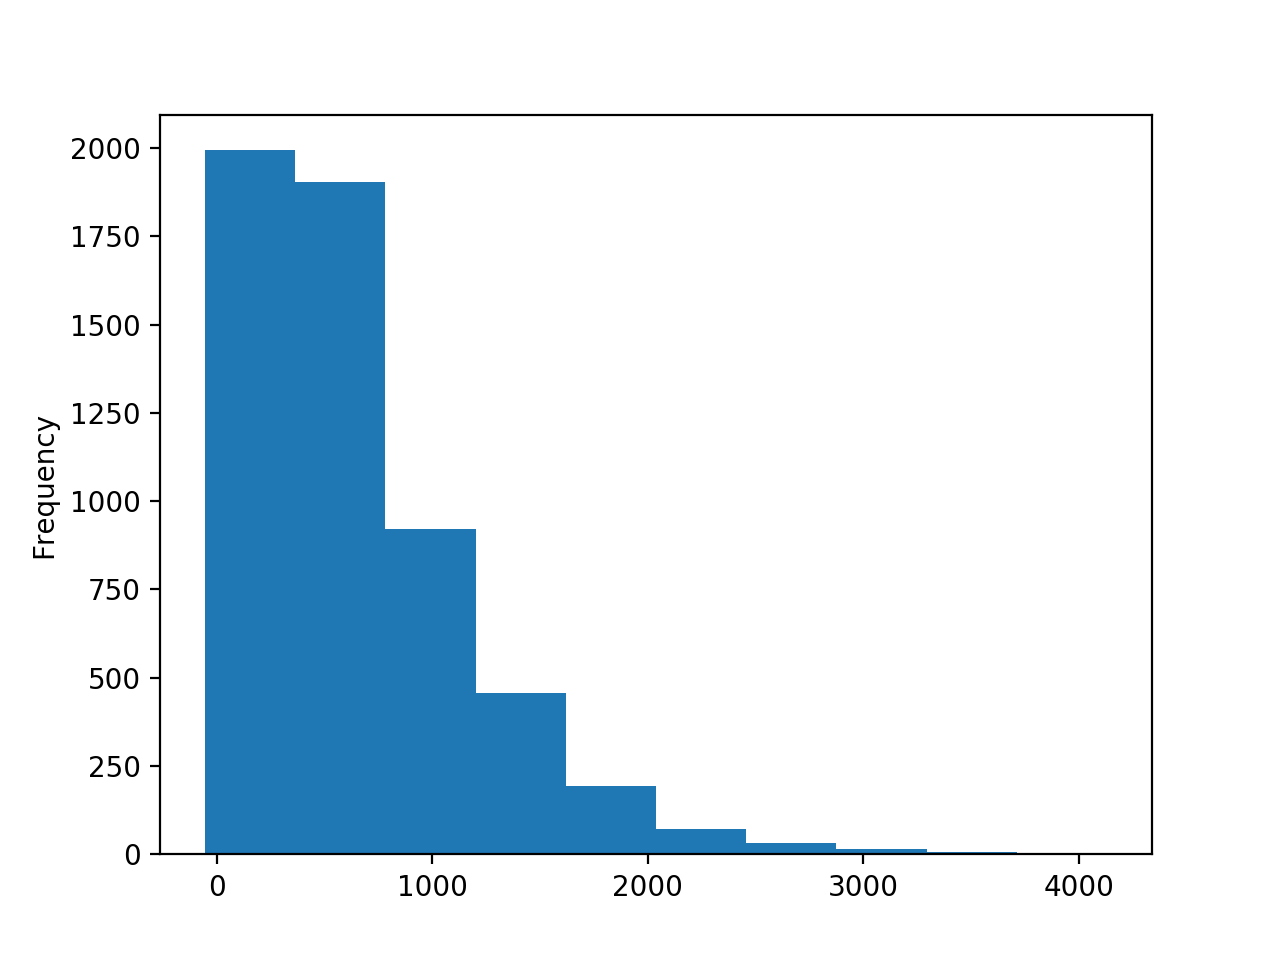

In [16]:
matches['t_first_kill'].plot(kind = 'hist')

# sen_log

In [15]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
sen_cnt = {
                'id':0,
                't_sen_cnt_3':0,
                't_sen_cnt_5':0,
                't_sen_cnt_8':0,
                't_sen_cnt_10':0,
                't_sen_cnt_12':0,
                't_sen_cnt_15':0,
                't_sen_cnt_20':0,
                't_sen_cnt_25':0,
                't_sen_cnt_30':0       
                }

sen = pd.DataFrame(columns = [key for key, value in sen_cnt.items()])

for i in range(0, len(matches['sen_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    sen_cnt = {
                'id':0,
                't_sen_cnt_3':0,
                't_sen_cnt_5':0,
                't_sen_cnt_8':0,
                't_sen_cnt_10':0,
                't_sen_cnt_12':0,
                't_sen_cnt_15':0,
                't_sen_cnt_20':0,
                't_sen_cnt_25':0,
                't_sen_cnt_30':0,
                't_sen_rpm_3':0,
                't_sen_rpm_5':0,
                't_sen_rpm_8':0,
                't_sen_rpm_10':0,
                't_sen_rpm_12':0,
                't_sen_rpm_15':0,
                't_sen_rpm_20':0,
                't_sen_rpm_25':0,
                't_sen_rpm_30':0    
                }
    try: 
        if matches['sen_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['sen_log'][i])):
                for timeStamp in timeStamps:
                    if matches['sen_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_sen_cnt_" + timeStamp
                        varName_rpm = "t_sen_rpm_" + timeStamp
                        sen_cnt[varName_cnt] += 1
                        sen_cnt[varName_rpm] += 1 / float(timeStamp)
            sen_cnt['id'] = matches['id'][i]
            senRow = pd.DataFrame.from_dict(sen_cnt, orient = 'index').transpose()
            sen = sen.append(senRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [16]:
matches = matches.merge(sen, left_on='id', right_on='id', how='inner')
matches.shape

(5380, 110)

# Возникают новые записи в таблице, хотя используется inner join. С чем это может быть связано?

# obs_log

In [78]:
def aggregate_by_times(log, log_name, times=None):
    aggregations = {}
    if times is None:
        times = [t for t in range(0, 31) if t % 5 == 0]
    for agg_type in ('cnt', 'rpm'):
        aggregations.update({
            't_{}_{}_{}'.format(log_name, t, agg_type): 0 
            for t in times
        })
        for record in log:
            for t in times:
                if record['time'] <= t * 60:
                    agg_name = 't_{}_{}_{}'.format(log_name, t, agg_type)
                    if agg_type == 'cnt':
                        aggregations[agg_name] += 1
                    elif agg_type == 'rpm':
                        aggregations[agg_name] += 1 / float(t if t != 0 else 1)      
    return aggregations

In [89]:
df_observers = pd.DataFrame(matches['obs_log'].apply(lambda obs_log: aggregate_by_times(obs_log, 'obs')).tolist())

In [93]:
pd.concat([matches, df_observers], axis=1).head()

,account_id,assists,attack_type,buyback_log,camps_stacked,cluster,creeps_stacked,deaths,denies,duration,...,t_obs_15_cnt,t_obs_15_rpm,t_obs_20_cnt,t_obs_20_rpm,t_obs_25_cnt,t_obs_25_rpm,t_obs_30_cnt,t_obs_30_rpm,t_obs_5_cnt,t_obs_5_rpm
0,111189717,6,Melee,[],2.0,224,6.0,3,12,1704,...,0,0.000000,0,0.00,0,0.0,0,0.000000,0,0.0
1,148215639,7,Ranged,[],0.0,224,0.0,6,13,1704,...,0,0.000000,0,0.00,0,0.0,0,0.000000,0,0.0
2,90882159,5,Ranged,[],0.0,224,0.0,4,12,1704,...,0,0.000000,0,0.00,0,0.0,0,0.000000,0,0.0
3,114239371,6,Melee,[],0.0,224,0.0,6,1,1704,...,4,0.266667,4,0.20,5,0.2,5,0.166667,1,0.2
4,119576842,8,Ranged,[],0.0,224,0.0,5,3,1704,...,3,0.200000,5,0.25,5,0.2,5,0.166667,1,0.2


In [17]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
obs_cnt = {
                'id':0,
                't_obs_cnt_3':0,
                't_obs_cnt_5':0,
                't_obs_cnt_8':0,
                't_obs_cnt_10':0,
                't_obs_cnt_12':0,
                't_obs_cnt_15':0,
                't_obs_cnt_20':0,
                't_obs_cnt_25':0,
                't_obs_cnt_30':0       
                }

obs = pd.DataFrame(columns = [key for key, value in obs_cnt.items()])

for i in range(0, len(matches['obs_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    obs_cnt = {
                'id':0,
                't_obs_cnt_3':0,
                't_obs_cnt_5':0,
                't_obs_cnt_8':0,
                't_obs_cnt_10':0,
                't_obs_cnt_12':0,
                't_obs_cnt_15':0,
                't_obs_cnt_20':0,
                't_obs_cnt_25':0,
                't_obs_cnt_30':0,
                't_obs_rpm_3':0,
                't_obs_rpm_5':0,
                't_obs_rpm_8':0,
                't_obs_rpm_10':0,
                't_obs_rpm_12':0,
                't_obs_rpm_15':0,
                't_obs_rpm_20':0,
                't_obs_rpm_25':0,
                't_obs_rpm_30':0    
                }
    try: 
        if matches['obs_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['obs_log'][i])):
                for timeStamp in timeStamps:
                    if matches['obs_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_obs_cnt_" + timeStamp
                        varName_rpm = "t_obs_rpm_" + timeStamp
                        obs_cnt[varName_cnt] += 1
                        obs_cnt[varName_rpm] += 1 / float(timeStamp)
            obs_cnt['id'] = matches['id'][i]
            obsRow = pd.DataFrame.from_dict(obs_cnt, orient = 'index').transpose()
            obs = obs.append(obsRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [18]:
matches = matches.merge(obs, left_on='id', right_on='id', how='inner')
print(matches.shape)

(5380, 128)


# runes_log

In [19]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
runes_cnt = {
                'id':0,
                't_runes_cnt_3':0,
                't_runes_cnt_5':0,
                't_runes_cnt_8':0,
                't_runes_cnt_10':0,
                't_runes_cnt_12':0,
                't_runes_cnt_15':0,
                't_runes_cnt_20':0,
                't_runes_cnt_25':0,
                't_runes_cnt_30':0       
                }

runes = pd.DataFrame(columns = [key for key, value in runes_cnt.items()])

for i in range(0, len(matches['runes_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    runes_cnt = {
                'id':0,
                't_runes_cnt_3':0,
                't_runes_cnt_5':0,
                't_runes_cnt_8':0,
                't_runes_cnt_10':0,
                't_runes_cnt_12':0,
                't_runes_cnt_15':0,
                't_runes_cnt_20':0,
                't_runes_cnt_25':0,
                't_runes_cnt_30':0,
                't_runes_rpm_3':0,
                't_runes_rpm_5':0,
                't_runes_rpm_8':0,
                't_runes_rpm_10':0,
                't_runes_rpm_12':0,
                't_runes_rpm_15':0,
                't_runes_rpm_20':0,
                't_runes_rpm_25':0,
                't_runes_rpm_30':0    
                }
    try:
        if matches['runes_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['runes_log'][i])):
                for timeStamp in timeStamps:
                    if matches['runes_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_runes_cnt_" + timeStamp
                        varName_rpm = "t_runes_rpm_" + timeStamp
                        runes_cnt[varName_cnt] += 1
                        runes_cnt[varName_rpm] += 1 / float(timeStamp)
            runes_cnt['id'] = matches['id'][i]
            runesRow = pd.DataFrame.from_dict(runes_cnt, orient = 'index').transpose()
            runes = runes.append(runesRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [20]:
matches = matches.merge(runes, left_on='id', right_on='id', how='inner')
matches.shape  

(5380, 146)

# buyback_log

In [21]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
buyback_cnt = {
                'id':0,
                't_buyback_cnt_3':0,
                't_buyback_cnt_5':0,
                't_buyback_cnt_8':0,
                't_buyback_cnt_10':0,
                't_buyback_cnt_12':0,
                't_buyback_cnt_15':0,
                't_buyback_cnt_20':0,
                't_buyback_cnt_25':0,
                't_buyback_cnt_30':0       
                }

buyback = pd.DataFrame(columns = [key for key, value in buyback_cnt.items()])

for i in range(0, len(matches['buyback_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    buyback_cnt = {
                'id':0,
                't_buyback_cnt_3':0,
                't_buyback_cnt_5':0,
                't_buyback_cnt_8':0,
                't_buyback_cnt_10':0,
                't_buyback_cnt_12':0,
                't_buyback_cnt_15':0,
                't_buyback_cnt_20':0,
                't_buyback_cnt_25':0,
                't_buyback_cnt_30':0,
                't_buyback_rpm_3':0,
                't_buyback_rpm_5':0,
                't_buyback_rpm_8':0,
                't_buyback_rpm_10':0,
                't_buyback_rpm_12':0,
                't_buyback_rpm_15':0,
                't_buyback_rpm_20':0,
                't_buyback_rpm_25':0,
                't_buyback_rpm_30':0    
                }
    try: 
        if matches['buyback_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['buyback_log'][i])):
                for timeStamp in timeStamps:
                    if matches['buyback_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_buyback_cnt_" + timeStamp
                        varName_rpm = "t_buyback_rpm_" + timeStamp
                        buyback_cnt[varName_cnt] += 1
                        buyback_cnt[varName_rpm] += 1 / float(timeStamp)
            buyback_cnt['id'] = matches['id'][i]
            buybackRow = pd.DataFrame.from_dict(buyback_cnt, orient = 'index').transpose()
            buyback = buyback.append(buybackRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [22]:
matches = matches.merge(buyback, left_on='id', right_on='id', how='inner')
matches.shape

(5380, 164)

In [23]:
buyback.shape

(5380, 19)

# Hero statistics

In [139]:
urlHeroes = "https://api.opendota.com/api/heroStats"

In [140]:
resp = requests.get('https://api.opendota.com/api/heroStats')
data = resp.json()
if resp.status_code == 400 and data is not None:
    sys.stderr.write(data['err'])
resp.raise_for_status()

In [162]:
def create_hero_stats_table():
    hero_stats_url = 'https://api.opendota.com/api/heroStats'
    resp = requests.get(hero_stats_url)
    data = resp.json()
    if resp.status_code == 400 and data is not None:
        sys.stderr.write(data.get('error'))
    resp.raise_for_status()
    df_heroes = pd.DataFrame(data)
    df_heroes.drop(['id', 'icon', 'img', 'name', 'roles'], axis=1, inplace=True)
    return df_heroes
df_heroes = create_hero_stats_table()
df_heroes.head()

,1000_pick,1000_win,2000_pick,2000_win,3000_pick,3000_win,4000_pick,4000_win,5000_pick,5000_win,...,legs,localized_name,move_speed,primary_attr,pro_ban,pro_pick,pro_win,projectile_speed,str_gain,turn_rate
0,11678,6037,28573,15250,36313,19432,12208,6346,1897,932,...,2,Anti-Mage,310,agi,239.0,87.0,48.0,0,1.3,0.5
1,8263,4389,17031,8904,17566,8975,4757,2432,563,265,...,2,Axe,290,str,10.0,20.0,12.0,900,2.8,0.6
2,2549,1160,6521,3006,8930,4239,3290,1576,710,363,...,4,Bane,310,int,274.0,166.0,93.0,900,2.4,0.6
3,9865,5093,18436,9441,18941,9778,5613,2834,967,496,...,2,Bloodseeker,285,agi,126.0,65.0,33.0,900,2.7,0.5
4,6142,3345,14055,7664,16953,9076,5128,2656,635,333,...,2,Crystal Maiden,275,int,8.0,10.0,2.0,900,2.0,0.5


In [168]:
dota_hero_roles = [
    'Carry', 'Disabler', 'Initiator', 'Jungler',
    'Support', 'Durable', 'Nuker', 'Escape', 'Pusher',
]

In [170]:
df_hero_roles = pd.DataFrame(columns=dota_hero_roles)
df_hero_roles.append()

,Carry,Disabler,Initiator,Jungler,Support,Durable,Nuker,Escape,Pusher


In [172]:
roles_lst = ['Support', 'Nuker', 'Disabler', 'Durable', 'Initiator']
{role: 1 for role in roles_lst}

{'Disabler': 1, 'Durable': 1, 'Initiator': 1, 'Nuker': 1, 'Support': 1}

In [177]:
matches['role_log'].apply(lambda hero_roles_list: {role: 1 for role in hero_roles_list}).apply(pd.Series).head()

,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
1,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0
2,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN
3,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0
4,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [137]:
heroesList = list()
heroAttr = [
            'id',
            'localized_name', 
            'attack_type',
            'pro_ban', 
            'pro_pick', 
            'pro_win', 
            'primary_attr', 
            'roles'
            ]
heroRolesList = [
                'Carry',
                'Disabler',
                'Initiator',
                'Jungler',
                'Support',
                'Durable',
                'Nuker',
                'Escape',
                'Pusher'
                ]

for heroId in range(0, len(dictData) - 1):    
    heroRaw = dict()
    
    for heroRole in heroRolesList:
        heroRaw[heroRole] = 0
    for key, value in dictData[heroId].items():
        if key in heroAttr:
            heroRaw[key] = dictData[heroId][key]
            if key == 'roles':
                for heroRole in dictData[heroId][key]:
                    heroRaw[heroRole] = 1
    del heroRaw['roles']                
    heroesList.append(heroRaw)

In [138]:
heroes = pd.DataFrame(heroesList)
print(heroes.shape)
heroes.head()

(114, 16)


,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support,attack_type,id,localized_name,primary_attr,pro_ban,pro_pick,pro_win
0,1,0,0,1,0,0,1,0,0,Melee,1,Anti-Mage,agi,239.0,87.0,48.0
1,0,1,1,0,1,1,0,0,0,Melee,2,Axe,str,10.0,20.0,12.0
2,0,1,1,0,0,0,1,0,1,Ranged,3,Bane,int,274.0,166.0,93.0
3,1,1,0,0,1,1,1,0,0,Melee,4,Bloodseeker,agi,126.0,66.0,33.0
4,0,1,0,0,0,1,1,0,1,Ranged,5,Crystal Maiden,int,8.0,10.0,2.0


# Возможно косяк здесь, потому что есть по 4 записи на команду, а не 5

In [28]:
matches.groupby(['team_id', 'match_id'], as_index=False).count()

,team_id,match_id,account_id,assists,attack_type,buyback_log,camps_stacked,cluster,creeps_stacked,deaths,...,t_buyback_cnt_8,t_buyback_rpm_10,t_buyback_rpm_12,t_buyback_rpm_15,t_buyback_rpm_20,t_buyback_rpm_25,t_buyback_rpm_3,t_buyback_rpm_30,t_buyback_rpm_5,t_buyback_rpm_8
0,3.0,3275808176,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,3.0,3276098324,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,3.0,3276229201,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,3.0,3276392063,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,3.0,3277831396,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,3.0,3278010775,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
6,3.0,3278177232,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
7,3.0,3278441447,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
8,3.0,3278675143,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
9,3.0,3278898021,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [29]:
matches= matches.merge(heroes, left_on = 'hero_id', right_on = 'id', how = 'inner')
matches.shape

(5367, 180)

# EXP_RPM

In [30]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
var = 'experience'
varTemplate = 't_' + var + '_'
for timeStamp in timeStamps:
    varName_cnt = varTemplate + 'cnt_' + timeStamp
    varName_rpm = varTemplate + 'rpm_' + timeStamp
    matches[varName_rpm] = matches[varName_cnt] / float(timeStamp)

# GOLD_RPM

In [31]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
var = 'gold'
varTemplate = 't_' + var + '_'
for timeStamp in timeStamps:
    varName_cnt = varTemplate + 'cnt_' + timeStamp
    varName_rpm = varTemplate + 'rpm_' + timeStamp
    matches[varName_rpm] = matches[varName_cnt] / float(timeStamp)

# LASTHITS_RPM

In [32]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
var = 'lasthits'
varTemplate = 't_' + var + '_'
for timeStamp in timeStamps:
    varName_cnt = varTemplate + 'cnt_' + timeStamp
    varName_rpm = varTemplate + 'rpm_' + timeStamp
    matches[varName_rpm] = matches[varName_cnt] / float(timeStamp)

In [33]:
for col in list(matches):
    print(col)

account_id
assists
attack_type_x
buyback_log
camps_stacked
cluster
creeps_stacked
deaths
denies
duration
first_blood_time
gold_per_min
gold_spent
hero_damage
hero_healing
hero_id
kills
kills_log
last_hits
leagueid
leaguename
level
localized_name_x
match_id
obs_log
ping_log
player_slot
primary_attr_x
purchase_log
role_log
runes_log
sen_log
start_time
stuns
t_experience_cnt_10
t_experience_cnt_12
t_experience_cnt_15
t_experience_cnt_20
t_experience_cnt_25
t_experience_cnt_3
t_experience_cnt_30
t_experience_cnt_5
t_experience_cnt_8
t_gold_cnt_10
t_gold_cnt_12
t_gold_cnt_15
t_gold_cnt_20
t_gold_cnt_25
t_gold_cnt_3
t_gold_cnt_30
t_gold_cnt_5
t_gold_cnt_8
t_lasthits_cnt_10
t_lasthits_cnt_12
t_lasthits_cnt_15
t_lasthits_cnt_20
t_lasthits_cnt_25
t_lasthits_cnt_3
t_lasthits_cnt_30
t_lasthits_cnt_5
t_lasthits_cnt_8
team_id
tower_damage
win
xp_per_min
id_x
datetime
t_item_aether_lens
t_item_arcane_boots
t_item_black_king_bar
t_item_blade_mail
t_item_blink
t_item_boots
t_item_bottle
t_item_desolat

# Заметка: после join появляются id_x и id_y - айдишники правых и левых таблиц

In [34]:
print(matches['id_x'].unique().size)

5367


In [35]:
print(matches['id_y'].unique().size)

111


# Используем id_x в качестве уникального id.
Аналог SQL select distinct id_x from matches (Удаляем дубликаты)

In [36]:
matches.drop_duplicates(subset = 'id_x', inplace = True)

In [37]:
matches.shape

(5367, 207)

In [38]:
matchesWithoutLogs = matches.drop(labels = ['buyback_log', 'kills_log', 'obs_log', 'ping_log', 'purchase_log', 'role_log', 'runes_log', 'sen_log'], axis = 1)

# Добавление ролей игроков

In [39]:
playersRoles = download_google_spreadsheet('https://docs.google.com/spreadsheets/d/e/2PACX-1vRV7SmVCA3a-IgxDRmhEJjFwLner7tEgRXHy_gcgav7GF2pCv4bOlwwt6B8RHkBP8LxV6Idf3zVVnze/pub?output=csv')

In [40]:
playersRoles.head()

,team,player,role,account_id
0,OG,n0tail,1,19672354
1,OG,ana,2,311360822
2,OG,JerAx,4,26771994
3,OG,s4,3,41231571
4,OG,Fly,5,94155156


In [41]:
matchesWithoutLogs = matchesWithoutLogs.merge(playersRoles, left_on = 'account_id', right_on = 'account_id', how = 'left')
matchesWithoutLogs.shape

(5408, 202)

In [42]:
matchesWithoutLogs.drop_duplicates(subset = 'id_x', inplace = True)
matchesWithoutLogs.shape

(5367, 202)

In [47]:
matchesWithoutLogs.to_csv('ABT.csv', na_rep = 'NaN', sep = ';')